In [3]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import scipy.fft as fft
import scipy.signal as sig
from mpl_toolkits import mplot3d

In [4]:
def han(t) :
    T=t[-1]-t[0]
    return((1/2)  -   (1/2)*np.cos(2 *np.pi* ((t-t[0])/T)))

def fourierfen(data): #fft
    resft=[]
    resfr=[]
    
    for i in data :
        t=i[0]
        n=len(t)
    
        windowed=han(t)*i[1] #tester differentes fenetre
    
    
        f=fft.fft(windowed)
        ft=fft.fftshift(f)
        
        feq=fft.fftfreq(n,d=t[1]-t[0])
        freq=fft.fftshift(feq)
        
        resft.append(ft)
        resfr.append(freq)
        
    res=[resfr,resft]
    return(res)
    # le tableau des N fft
    
def importfour(path,path1="./fft",save=False) :  
    fichier=glob.glob(path) #Importation donnée
    data=[]
    for i in fichier :
        data.append(np.loadtxt("{}".format(i),unpack=True,delimiter=","))
        
    res=fourierfen(data)
    if save == True :
        np.save(path1,res)
    return(res)


def mask(res,ind=0,plot=True) : #renvoie UN trio freq amp phase
    
    mfreq=[]
    mamp=[]
    mphase=[]
    
    n=len(res[0])
    amp=res[1][ind] #l'amplitude
    
    v=amp
    vmo=v*v.conj() #MODULE CARREE
    vmod=vmo.real

    phase=np.arctan2(amp.imag,amp.real)
    
    a=sig.find_peaks(vmod,height=1e-2,threshold=0.04,distance=35)
    maxfreq=res[0][ind][a[0]]
        
    misc=np.where(maxfreq>0) #Mask frequence superieure a 0
        
    mfreq.append(maxfreq[misc]) #freq sup 0
    mamp.append(vmod[a[0]][misc]) #module carre sup 0
    mphase.append(phase[a[0]][misc]) #phase sup 0
        
    if plot== True :
        plt.figure(figsize=[10,5])
        plt.semilogy(maxfreq,vmod[a[0]],linestyle="",marker="x",color="red",label="Amplitude maximale")
        plt.plot(maxfreq,phase[a[0]],linestyle="",marker="x",color="green",label="phase")
        plt.semilogy(res[0][ind],vmod,label="fft")
        plt.xlim([0,max(res[0][ind])])
        plt.title("Graphe fft mesure {}".format(ind))
        plt.xlabel("Hz")
        plt.legend()
    
        plt.figure()
        plt.plot(maxfreq,phase[a[0]],linestyle="-",marker="x",color="green")
        plt.title("Graphe phase aux resonnance mesure {}".format(ind))
        plt.xlabel("Hz")
        
    dat=[mfreq,mamp,mphase]
        
    return(dat)

In [5]:
def finalplot(maxi,angledépart=10) :
    
    freq=[]
    amp=[]
    phase=[]
    angscatter=[]
    angle=np.arange(len(maxi))
    
    for i in range(len(maxi)) :
        freqmaxi=maxi[i][0][0].tolist() #liste d'array
        ampmaxi=maxi[i][1][0].tolist()
        phasemaxi=maxi[i][2][0].tolist()
        
        angle=i
        anglemultidim=np.ones(len(maxi[i][0][0]))*360 - (np.ones(len(maxi[i][0][0]))*i*5 +angledépart)
        anglemultidim=anglemultidim.tolist()
        
        
        freq=freq+freqmaxi
        amp=amp+ampmaxi
        phase=phase+phasemaxi
        angscatter=angscatter+anglemultidim #Un scatter n'acceptte qu'une séquence
    

    plt.figure(figsize=[20,10])
    plt.scatter(angscatter, freq,linewidths=1, alpha=.7,edgecolor='k',s = 200, c=amp)
    plt.title("Shift d'amplitude")
    plt.xlabel('Angle')
    plt.ylabel('freq')
    plt.colorbar()
    #plt.ylim(500,600)
    plt.vlines(angscatter,freq[0]-1,freq[0]+1,linestyle="solid")
    plt.vlines(angscatter,freq[1]-1,freq[1]+1)
    plt.vlines(angscatter,freq[2]-1,freq[2]+1)#valeur témoin
    plt.vlines(angscatter,freq[3]-1,freq[3]+1)
    
    plt.figure(figsize=[20,10])
    plt.scatter(angscatter, freq,linewidths=1, alpha=.7,edgecolor='k',s = 200, c=phase)
    plt.title("Shift de phase")
    plt.xlabel('Angle')
    plt.ylabel('freq')
    plt.colorbar()
    plt.vlines(angscatter,freq[0]-1,freq[0]+1,linestyle="solid")
    plt.vlines(angscatter,freq[1]-1,freq[1]+1)
    plt.vlines(angscatter,freq[2]-1,freq[2]+1)#valeur témoin
    plt.vlines(angscatter,freq[3]-1,freq[3]+1)
    
        
        
    f=np.array(freq) #On remet tout en tableau pour le surface plot
    p=np.array(phase)
    a=np.array(amp)
    an=np.array(angscatter)

    
    
    def injective(ang,freq,phase) : #sommes les freq et phase associé pour créer un truc a peu pres injectif
        nobruit=np.where(freq>400)
        angu=ang[nobruit]
        frequ=freq[nobruit]
        phaseu=phase[nobruit]
        
        res=np.array([])
        for i in range(len(angu)+1):
            a=0
            while angu[i] == angu[i+1] :
                 a+= (frequ[i]*phaseu[i])
            res.concatenate(a)
        return(res)
    
    resi=injective(an,f,p)
    ange=np.arrange(0,len(resi))
    angetrue= np.ones(len(ange))*360 - ange *5 *angledépart
    
    plt.figure()
    plt.plot(angetrue,resi)
    
            
                
        

In [6]:
res=importfour("C:/Users/efrem/ICC/1M/Angle/Mesures/*.csv*.csv","C:/Users/efrem/ICC/1M/Angle/Mesures/fft",save=False) #fft + save npy


maxi=[] #Liste qui a pout premier indent le numero de la mesure puis la freq amp ou phase
for i in range(len(res[0])): #Chaque element correspon a UNE MESURE
    maxi.append(mask(res,plot=False,ind=i)) # mask
    
mask(res,plot=True,ind=-5)

IndexError: list index out of range

IndexError: list index out of range

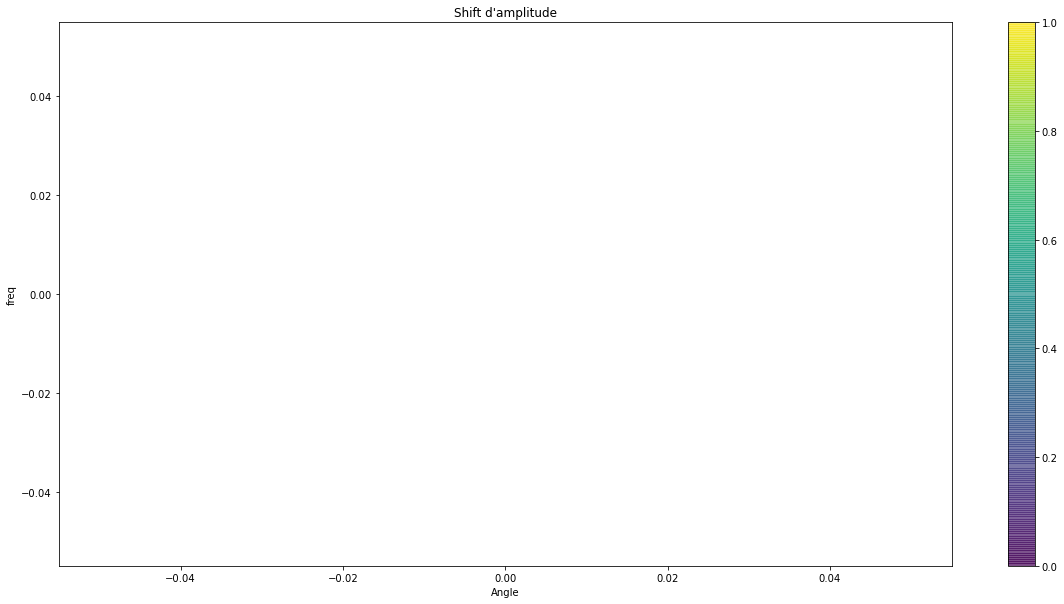

In [7]:
finalplot(maxi)